In [2]:
import numpy as np
import mne as mne
import matplotlib.pyplot as plt
from sklearn import svm

ELECTRODES_NUM = 35

root_folder = r"C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\sep_4th"
file_ext = ".set"

# Import the data

train_set = mne.io.read_epochs_eeglab(root_folder + r'\train_set.set')
test_set = mne.io.read_epochs_eeglab(root_folder + r'\test_set.set')
base_removed_train_set = mne.io.read_epochs_eeglab(root_folder + r'\base_removed_train_set.set')
base_removed_test_set = mne.io.read_epochs_eeglab(root_folder + r'\base_removed_test_set.set')

# Trim the data
trimmed_train_set = train_set.copy().crop(tmin=0.1, tmax=0.7)
trimmed_test_set = test_set.copy().crop(tmin=0.1, tmax=0.7)
trimmed_base_removed_train_set = train_set.copy().crop(tmin=0.1, tmax=0.7)
trimmed_base_removed_test_set = test_set.copy().crop(tmin=0.1, tmax=0.7)

trimmed_train_ica = mne.preprocessing.read_ica(root_folder + r'\trimmed_train_ica.fif')
trimmed_test_ica = mne.preprocessing.read_ica(root_folder + r'\trimmed_test_ica.fif')


obj_trimmed_train_reconstructed = []
obj_trimmed_test_reconstructed = []
for i in range(ELECTRODES_NUM):
    obj_trimmed_train_reconstructed.append(trimmed_train_ica.apply(trimmed_base_removed_train_set.copy(), include=i))
    obj_trimmed_test_reconstructed.append(trimmed_test_ica.apply(trimmed_base_removed_test_set.copy(), include=i))

obj_trimmed_train_ICs = trimmed_train_ica.get_sources(trimmed_base_removed_train_set)
obj_trimmed_test_ICs = trimmed_test_ica.get_sources(trimmed_base_removed_test_set)

Extracting parameters from C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\sep_4th\train_set.set...
Not setting metadata
369 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\sep_4th\test_set.set...
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\sep_4th\base_removed_train_set.set...
Not setting metadata
369 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from C:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\sep_4th\base_removed_test_set.set...
Not setting metadata
93 matching events found
No baseline correction applied
0 proj

In [3]:
trimmed_train_ICs_left_data = obj_trimmed_train_ICs['Left'].get_data()
trimmed_train_ICs_right_data = obj_trimmed_train_ICs['Right'].get_data()
trimmed_train_ICs_no_move_data = obj_trimmed_train_ICs['NoMove'].get_data()
trimmed_train_ICs_sorted_data = np.swapaxes(np.concatenate([trimmed_train_ICs_left_data, trimmed_train_ICs_right_data, trimmed_train_ICs_no_move_data]),0,1)
train_labels = [1] * trimmed_train_ICs_left_data.shape[0] + [2] * trimmed_train_ICs_right_data.shape[0] + [3]  * trimmed_train_ICs_no_move_data.shape[0]

trimmed_test_ICs_left_data = obj_trimmed_test_ICs['Left'].get_data()
trimmed_test_ICs_right_data = obj_trimmed_test_ICs['Right'].get_data()
trimmed_test_ICs_no_move_data = obj_trimmed_test_ICs['NoMove'].get_data()
trimmed_test_ICs_sorted_data = np.swapaxes(np.concatenate([trimmed_test_ICs_left_data, trimmed_test_ICs_right_data, trimmed_test_ICs_no_move_data]),0,1)
test_labels = [1] * trimmed_test_ICs_left_data.shape[0] + [2] * trimmed_test_ICs_right_data.shape[0] + [3]  * trimmed_test_ICs_no_move_data.shape[0]

c:\Users\alonb\anaconda3\envs\eeg_bss\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


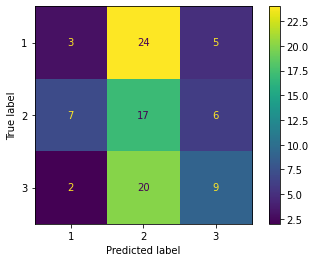

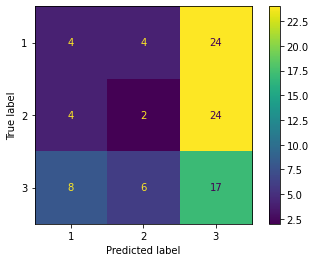

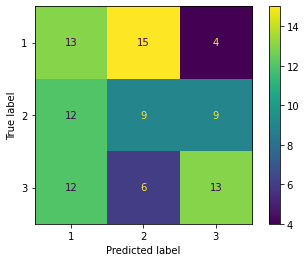

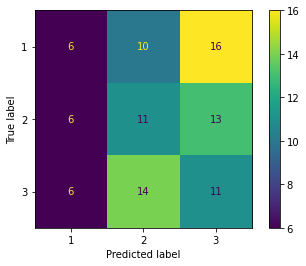

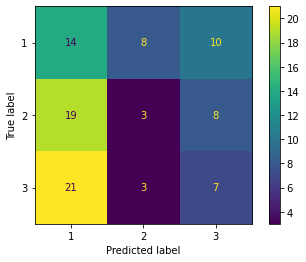

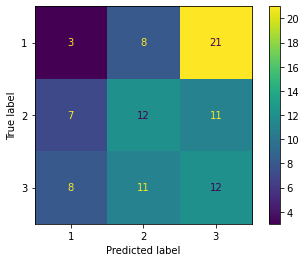

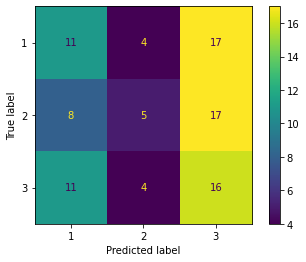

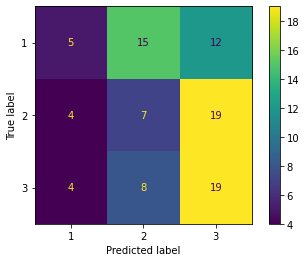

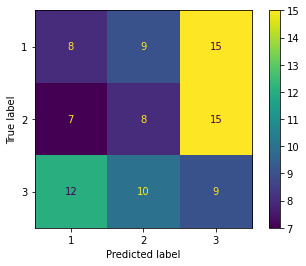

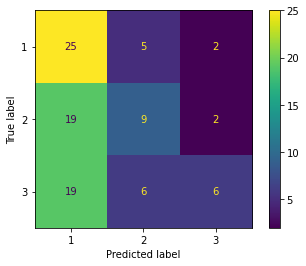

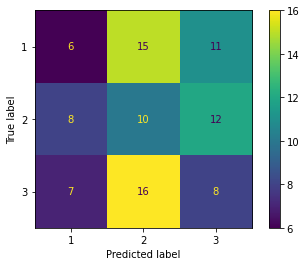

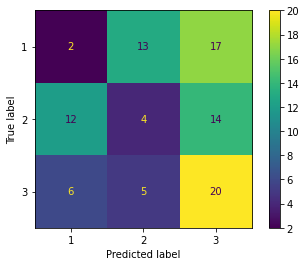

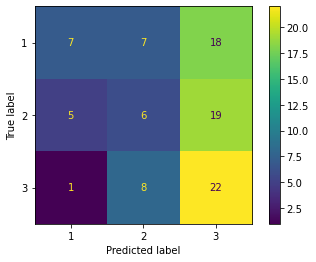

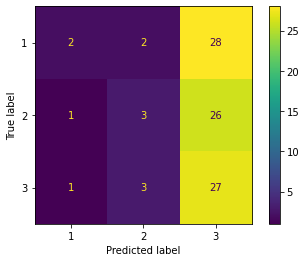

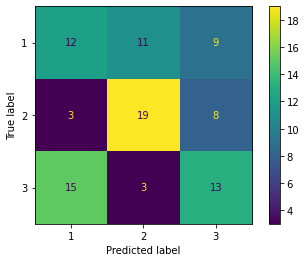

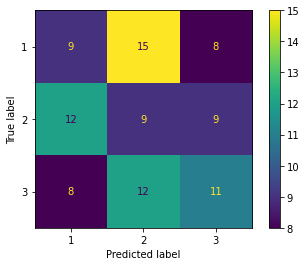

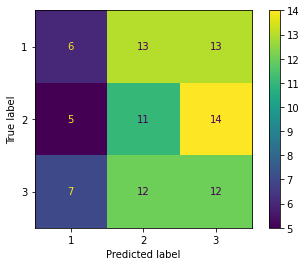

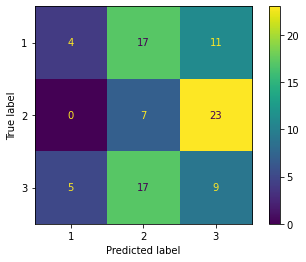

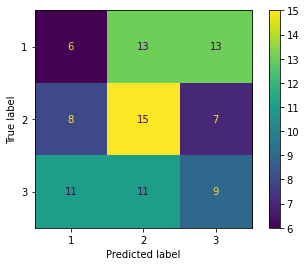

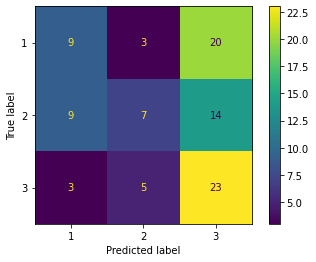

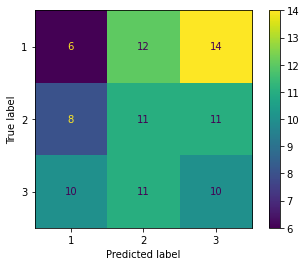

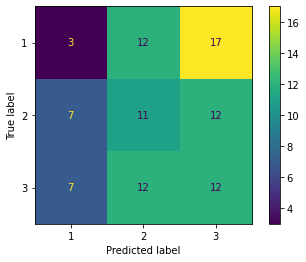

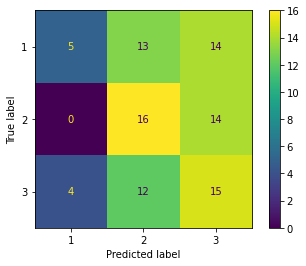

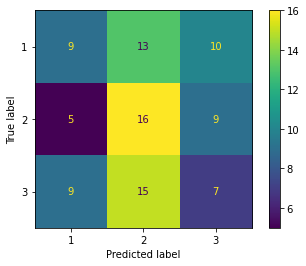

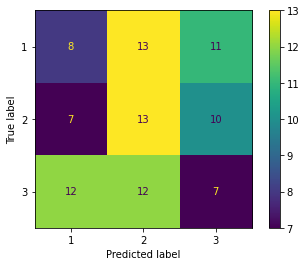

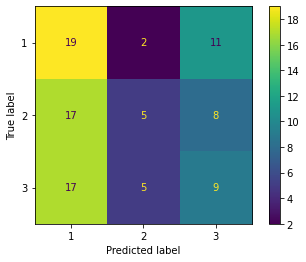

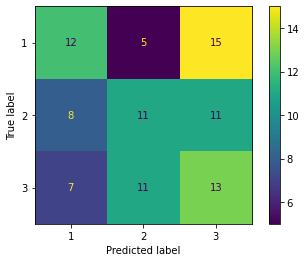

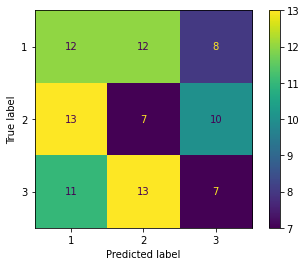

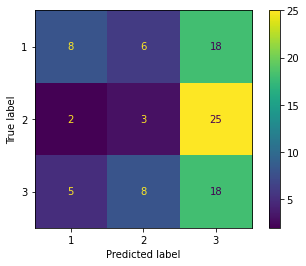

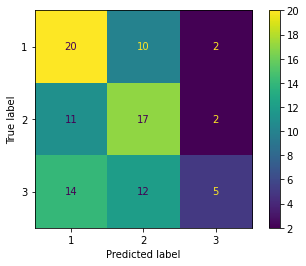

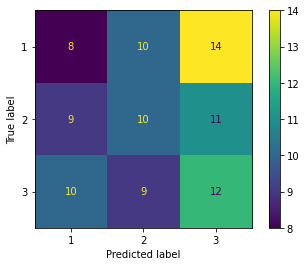

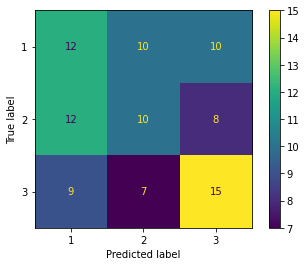

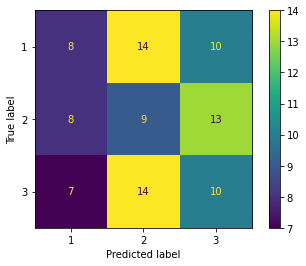

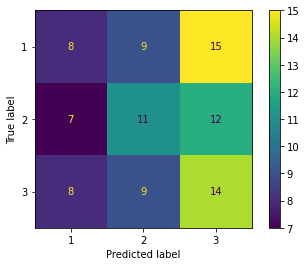

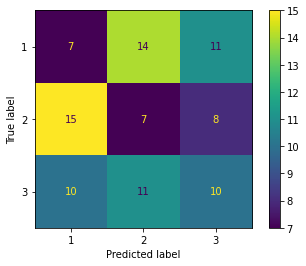

In [16]:
from sklearn import metrics

for i in range(ELECTRODES_NUM):
    clf = GaussianNB().fit(trimmed_train_ICs_sorted_data[i], train_labels)
    prediction = clf.predict(trimmed_test_ICs_sorted_data[i])
    # print(f"{metrics.classification_report(test_labels, prediction)}\n")
    disp = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, prediction)
    # disp.figure_.suptitle("Confusion Matrix")
    # print(f"Confusion matrix:\n{disp.confusion_matrix}")

<BarContainer object of 35 artists>

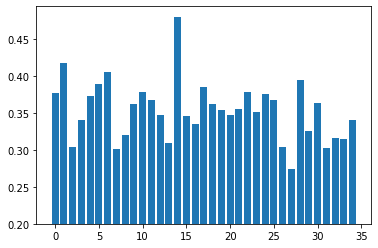

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


f1_scores = []
# accuracy_scores = []
for i in range(ELECTRODES_NUM):
    # clf = GaussianNB()
    clf = KNeighborsClassifier(n_neighbors=10)
    f1_scores.append(cross_val_score(clf, trimmed_train_ICs_sorted_data[i], train_labels, scoring='f1_macro').mean())
    # accuracy_scores.append(cross_val_score(clf, trimmed_train_ICs_sorted_data[i], train_labels).mean())
    # print(f"For IC {i} the F1 score is {f1_scores[i]} and the accuracy is {accuracy_scores[i]}.")
f1_scores = np.array(f1_scores)
# accuracy_scores = np.array(accuracy_scores)
bottom = 0.2
x = np.arange(ELECTRODES_NUM)
# plt.bar(x, accuracy_scores-f1_scores)
plt.bar(x, f1_scores-bottom, bottom=bottom)
# print(f"The average F1 score is {f1_scores.mean()} and the average accuracy is {accuracy_scores.mean()}.")

For IC 0 the score is 0.44294068504594813.
For IC 1 the score is 0.4592314118629908.
For IC 2 the score is 0.38888888888888884.
For IC 3 the score is 0.40192147034252296.
For IC 4 the score is 0.3027568922305764.
For IC 5 the score is 0.20985797827903088.
For IC 6 the score is 0.347702589807853.
For IC 7 the score is 0.32322472848788636.
For IC 8 the score is 0.43609022556390975.
For IC 9 the score is 0.3323308270676692.
For IC 10 the score is 0.39816207184628233.
For IC 11 the score is 0.5446950710108605.
For IC 12 the score is 0.37961570593149535.
For IC 13 the score is 0.3568922305764411.
For IC 14 the score is 0.4573934837092732.
For IC 15 the score is 0.26666666666666666.
For IC 16 the score is 0.2584795321637427.
For IC 17 the score is 0.304093567251462.
For IC 18 the score is 0.2698412698412698.
For IC 19 the score is 0.33107769423558897.
For IC 20 the score is 0.2704260651629073.
For IC 21 the score is 0.3430242272347535.
For IC 22 the score is 0.3477025898078529.
For IC 23 the

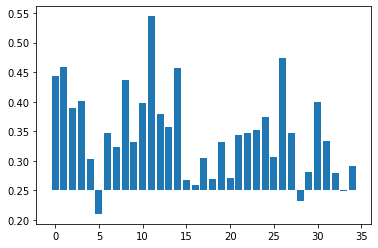

In [8]:
from sklearn.model_selection import cross_val_score

    
classifiers = []
for i in range(ELECTRODES_NUM):
    classifiers.append([])
    for c in (0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1):
        # classifiers[-1].append(svm.SVC(C=c))
        classifiers[-1].append(svm.SVC(C=c, kernel="sigmoid"))
classifiers_len = len(classifiers[0])
scores = np.empty((ELECTRODES_NUM, classifiers_len))
for i in range(ELECTRODES_NUM):
    for j in range(classifiers_len):
        # score = cross_val_score(classifiers[i][j], trimmed_train_ICs_sorted_data[i], train_labels, scoring='f1_macro')
        score = cross_val_score(classifiers[i][j], trimmed_test_ICs_sorted_data[i], test_labels)
        scores[i,j] = score.mean()
scores = np.mean(scores, axis=1)
for i in range(ELECTRODES_NUM):
    print(f"For IC {i} the score is {scores[i]}.")
bottom = 0.25
x = np.arange(ELECTRODES_NUM)
plt.bar(x, scores-bottom, bottom=bottom)
print(f"The average score is {scores.mean()}.")

c:\Users\alonb\anaconda3\envs\eeg_bss\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


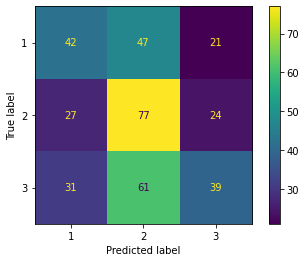

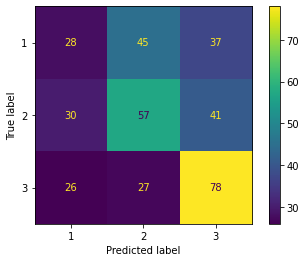

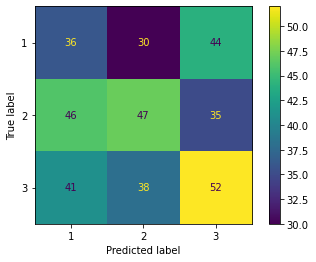

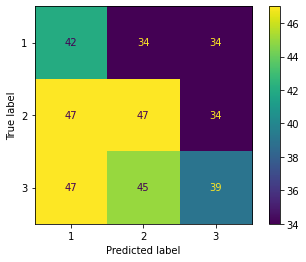

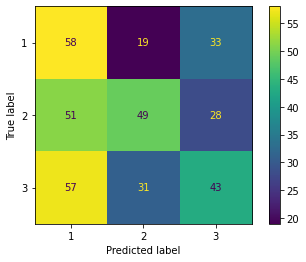

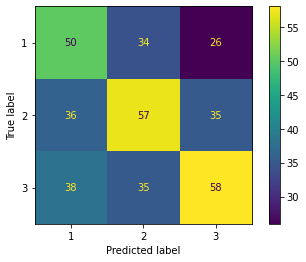

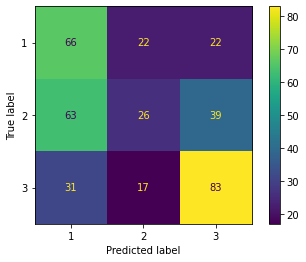

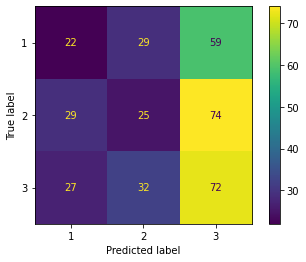

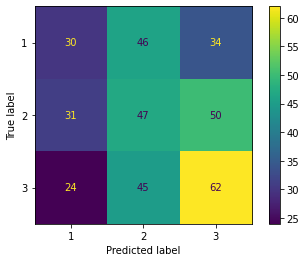

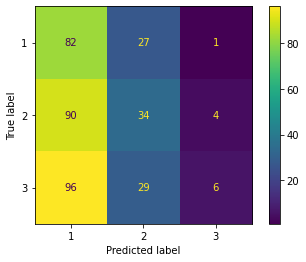

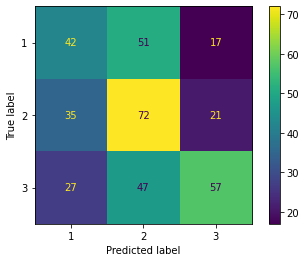

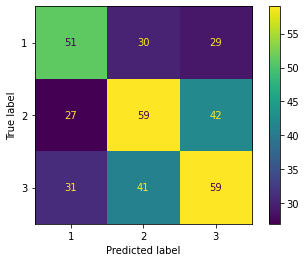

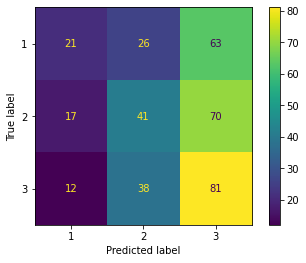

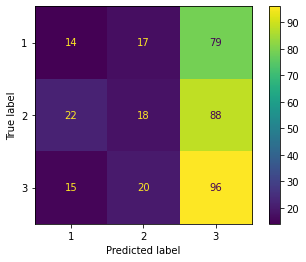

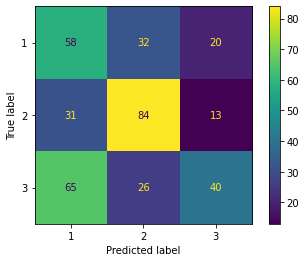

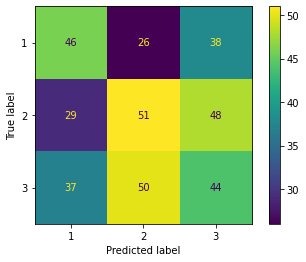

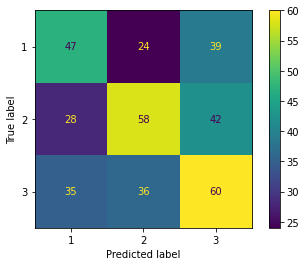

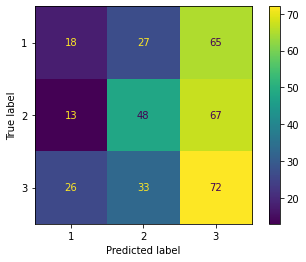

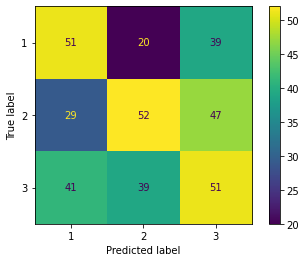

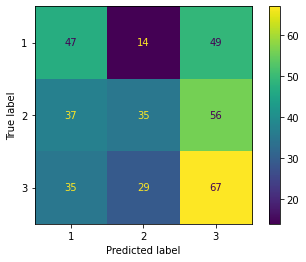

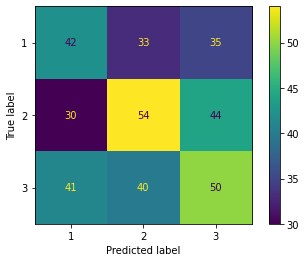

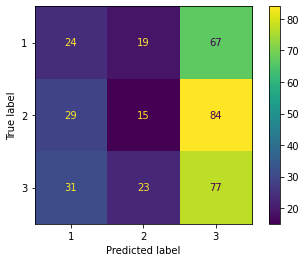

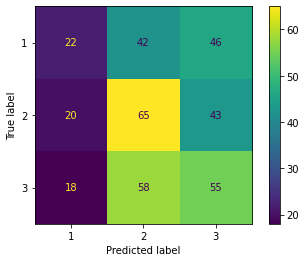

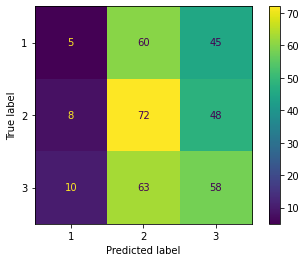

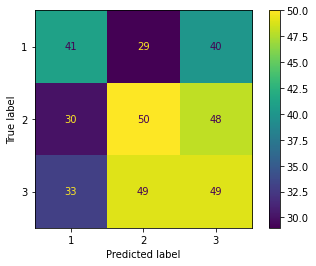

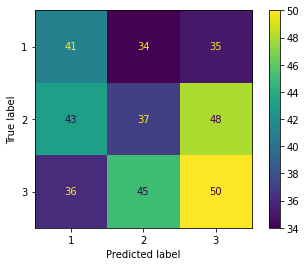

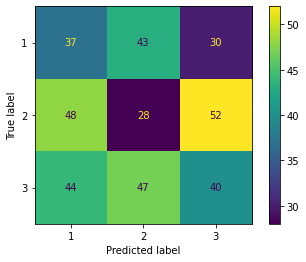

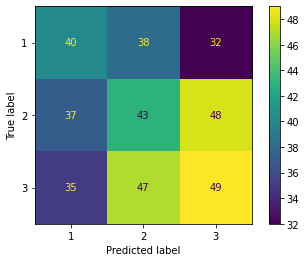

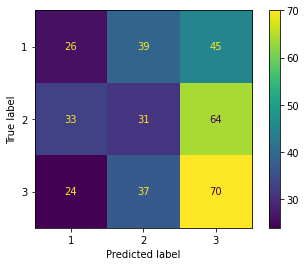

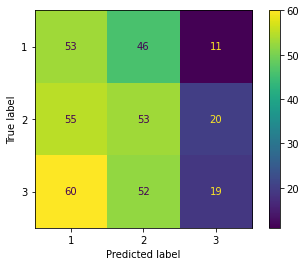

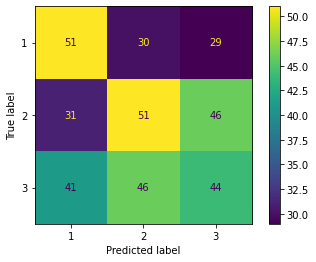

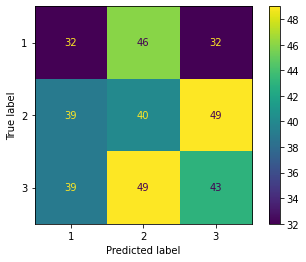

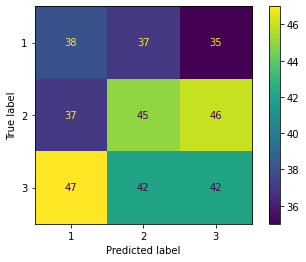

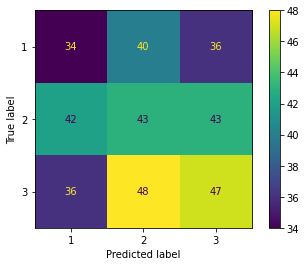

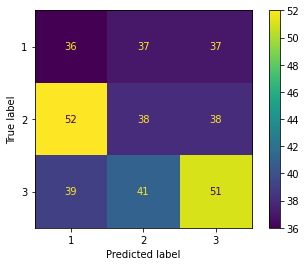

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict, cross_validate

for i in range(ELECTRODES_NUM):
    # clf = svm.SVC()
    # clf = KNeighborsClassifier(n_neighbors=15)
    clf = GaussianNB()
    pred = cross_val_predict(clf, trimmed_train_ICs_sorted_data[i], train_labels)
    disp = metrics.ConfusionMatrixDisplay.from_predictions(train_labels, pred)